# Модель машинного обучения для детекции и предотвращения мошенничества в кредитных операциях

**Автор: Кузьмин Дмитрий**

## Введение

Мошенничество существует с тех пор, как существует человечество, и может принимать бесконечное множество различных форм. Кроме того, развитие новых технологий предоставляет преступникам дополнительные способы совершения мошенничества, например, в электронной коммерции

Использование кредитных карт широко распространено в современном обществе, и мошенничество с кредитными картами неуклонно растет в последние годы. Финансовые потери из-за мошенничества затрагивают не только банки, но и отдельных клиентов. Если банк теряет деньги, клиенты в конечном итоге тоже платят через более высокие процентные ставки, повышенные членские взносы и т.д.

Обнаружение мошенничества — это процесс определения, принадлежит ли новая авторизованная транзакция к мошенническим или подлинным транзакциям, исходя из набора кредитных карт транзакций. Система обнаружения мошенничества (FDS) должна не только эффективно выявлять случаи мошенничества, но и быть экономически эффективной в том смысле, что стоимость, затрачиваемая на проверку транзакций, не должна превышать потери от мошенничества.

Техники машинного обучения базируются на выводе модели предсказания на основе набора примеров. Эта модель, чаще всего параметрическая функция, позволяет предсказывать вероятность того, что транзакция является мошенничеством, на основе набора характеристик, описывающих транзакцию. В области обнаружения мошенничества использование техник обучения привлекательно по ряду причин. 

1. Они позволяют обнаруживать закономерности в данных с высокой размерностью, т.е. транзакции поступают в виде непрерывного потока и каждая транзакция определяется многими переменными.
2. Мошеннические транзакции часто коррелируют во времени и пространстве. Например, мошенники обычно пытаются совершить аферы в одном магазине с разными картами в течение короткого периода времени.
3. Методы обучения могут использоваться для обнаружения и моделирования существующих мошеннических стратегий, а также для выявления новых стратегий, связанных с необычным поведением владельцев карт.

## Проблема несбалансированных данных

Обучение на несбалансированных данных сложно, так как большинство алгоритмов не рассчитаны на большой дисбаланс по классам. В литературе традиционные методы включают применение техник выборки для балансировки данных. Можно выделить методы на уровне данных и алгоритмов. На уровне данных применяют предварительную обработку для балансировки или удаления шума, а на уровне алгоритмов адаптируют методы для лучшего обнаружения класса меньшинства.

К методам обработки данных относятся:

- Недовыборка (undersampling) — уменьшение количества объектов класса большинства путём случайного удаления, что снижает дисбаланс, но риск потери полезной информации.

- Передовыборка (oversampling), включая SMOTE — увеличение класса меньшинства путём генерации новых синтетических примеров, что помогает увеличить количество данных, но может вызвать переобучение.

Методы на уровне алгоритмов включают взвешивание классов, специальные функции потерь и методы ансамблей.

## Этапы работы

1. Сбор и предварительная обработка данных
2. Предварительный анализ и масштабирование признаков
3. Обучение модели и выбор алгоритма
4. Оценка результатов

## О наборе данных

Используемый набор данных содержит транзакции по кредитным картам, совершённые в сентябре 2013 года европейскими держателями карт. Все входные признаки - числовые, являющиеся результатом преобразования главных компонент (PCA), что уменьшает размерность и убирает корреляции.

В наборе 31 числовая переменная, а также следующие важные признаки:

- Time - количество секунд, прошедших с момента первой транзакции в датасете до текущей транзакции. Этот признак помогает учитывать временную динамику транзакций.

- Amount - сумма транзакции, которая может влиять на вероятность мошенничества и использоваться для оценки экономической значимости.

- Class - целевая переменная, которая принимает значение 1 для мошеннических транзакций и 0 для легитимных.

Набор данных сильно несбалансирован: мошенничество составляет лишь 0.172% от всех транзакций (492 мошеннических из 284 807). Из-за отсутствия идентификатора владельца карты каждая транзакция рассматривается как независимый случай.

Для решения этой проблемы при обучении моделей применяется балансировка данных через создание подвыборок с равным соотношением мошеннических и нормальных транзакций - по 50% каждого класса, что позволяет модели лучше распознавать редкие мошеннические случаи и уменьшает риск смещения.

## Импорт библиотек

In [1]:
import warnings
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, roc_auc_score

## Чтение данных

In [2]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

## Реализация функции для обучения модели

In [3]:
def evaluate_model(
    model,
    X_train,
    y_train,
    X_test,
    y_test,
    model_name,
    subtitle=None,
    verbose=False,
    show_confusion_matrix=True,
):
    """
    Обучает модель и генерирует комплексные метрики оценки и визуализации.
    Параметры:
    ----------
    model : sklearn estimator
    Машинная обучающая модель для обучения и оценки
    X_train : array
    Признаки обучающей выборки
    y_train : array
    Целевая переменная обучающей выборки
    X_test : array
    Признаки тестовой выборки
    y_test : array-like
    Целевая переменная тестовой выборки
    model_name : str
    Название модели 
    subtitle : str, optional
    Дополнительный подзаголовок для матрицы ошибок
    verbose : bool, optional
    Выводит подробную информацию
    show_confusion_matrix : bool, optional
    Показывает матрицу ошибок
    Возвращает:
    -----------
    dict : Словарь, содержащий предсказания, вероятности, ROC-AUC
    """
    header = f"{model_name}"

    if verbose:
        print("=" * len(header))
        print(header)
        print("=" * len(header))
        
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    auc_score = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

    if verbose:
        print("\nClassification Report:")
        print(
            classification_report(
                y_test,
                y_pred,
                target_names=["Fraud", "Normal"],
                labels=[1, 0],
            )
        )
        print(f"\nROC AUC Score: {auc_score:.4f}")
        
    if show_confusion_matrix:
        
        plt.figure(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Fraud", "Normal"],
            yticklabels=["Fraud", "Normal"],
        )
        title = f"Confusion Matrix - {model_name}"
        if subtitle:
            title += f"\n{subtitle}"
        plt.title(title, fontweight="bold", fontsize=14, pad=20)
        
    return {
        "model": model,
        "predictions": y_pred,
        "probabilities": y_pred_proba,
        "auc_score": auc_score,
        "confusion_matrix": cm,
    }

## Модель логистической регрессии

Для начала будет обучена модель логистической регрессии без применения каких-либо методов балансировки классов. Поскольку эта модель достаточно проста, она служит базовым уровнем для сравнения её производительности с более сложными методами

Logistic Regression


D:\anaconda\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Classification Report:
              precision    recall  f1-score   support

       Fraud       0.85      0.58      0.69        95
      Normal       1.00      1.00      1.00     56651

    accuracy                           1.00     56746
   macro avg       0.92      0.79      0.84     56746
weighted avg       1.00      1.00      1.00     56746


ROC AUC Score: 0.9560


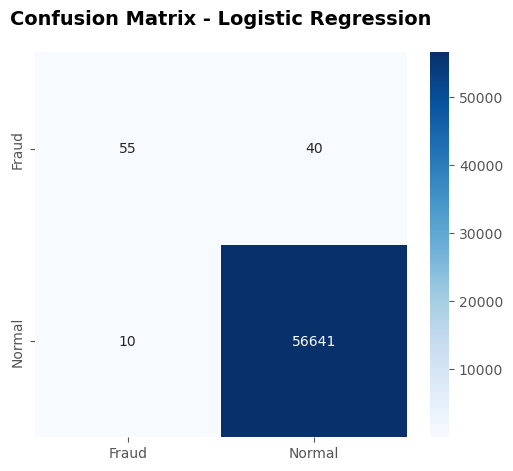

In [4]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
results_lr = evaluate_model(
    model=lr_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Logistic Regression",
    verbose=True,
    show_confusion_matrix=True
)

Данные результаты демонстрируют типичное поведение при работе с несбалансированными данными, где крайне важно анализировать такие метрики, как точность, полнота и F1-мера

- **Precision:** Показывает долю корректных положительных прогнозов. Рассчитывается как:

    $$
    \text{Precision} = \frac{TP}{TP + FP} = \frac{55}{55+10} = 0.8461
    $$

  где  $TP$ - это истинно-положительные случаи а $FP$ - ложно-положительные. Это означает, что 85% транзакций, классифицированных как мошеннические, действительно являлись таковыми.


- **Recall:** Показывает, какую долю реальных мошеннических операций модель смогла обнаружить. Рассчитывается как:

  $$
    \text{Recall} = \frac{TP}{TP + FN} = \frac{55}{55+40} = 0.5789
  $$

  где $FN$ ложно-отрицательные случаи. Модель обнаружила только 58% реальных мошеннических операций, оставив 42% невыявленными.
    
  В задаче обнаружения мошенничества полнота является более критичной метрикой, поскольку стоимость необнаруженного мошенничества (финансовые потери и репутационный ущерб) превышает стоимость ложной тревоги. Следовательно, необходимо максимизировать полноту, сохраняя приемлемую точность.


- **F1-Score:** Представляет собой гармоническое среднее между точностью и полнотой:

    $$
    \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2\times \frac{0.846 \times 0.58}{0.846 + 0.58} = 0.69
    $$

- **Confusion matrix:** 56 641 нормальных транзакции были корректно идентифицированы, как и 55 мошеннических операции. Однако 40 случаев мошенничества были ошибочно классифицированы как нормальные (ложно-отрицательные)

    Хотя число 40 может показаться небольшим на фоне общего количества транзакций, оно является значительным, учитывая, что тестовая выборка содержала всего 95 случаев мошенничества (из 492 в исходном наборе данных). Это представляет собой 42% необнаруженных мошеннических операций - критически важную долю, имеющую серьезные финансовые последствия.



## Модель логистической регрессии c балансировкой

Используется модель логистической регрессии, но на этот раз с указанием параметра `class_weight='balanced'`. Это позволяет модели автоматически сбалансировать веса классов, обратно пропорционально их частотам в обучающих данных, что приводит к большей стоимости за ошибки в миноритарном классе. Формула, используемая для расчета весов, выглядит следующим образом:

$$
\text{weight}_i = \frac{n_{\text{total}}}{n_{\text{classes}} \times n_i}
$$

Где:

$n_{\text{total}}$ — общее количество наблюдений,

$n_{\text{classes}}$ — количество классов (в данном случае 2),

$n_i$ — количество наблюдений в классе $i$.

Это заставляет модель уделять больше внимания случаям мошенничества в процессе обучения, компенсируя дисбаланс классов и потенциально улучшая способность модели обнаруживать редкие, но важные мошеннические транзакции.

D:\anaconda\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


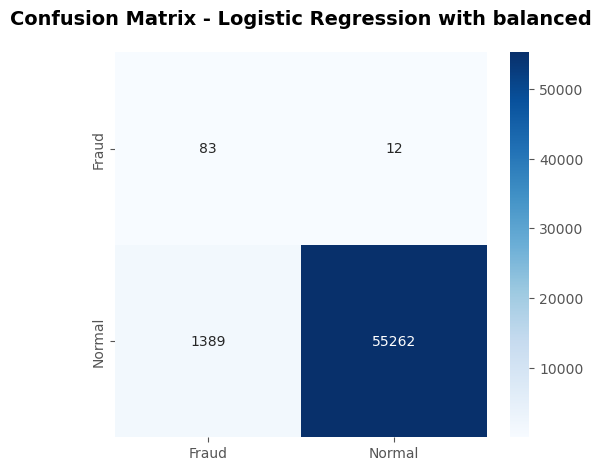

In [5]:
lr_balanced = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
results_lr_balanced = evaluate_model(
    model=lr_balanced,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    model_name="Logistic Regression with balanced",
    show_confusion_matrix=True
)

Данные результаты демонстрируют еще более выраженное поведение: меньше ложно-отрицательных результатов ценой увеличения ложноположительных срабатываний

- **Precision:** Составляет всего около 6%, генерируя 1 389 ложноположительных результатов (нормальные транзакции, ошибочно классифицированные как мошеннические):

    $$
    \text{Precision} = \frac{TP}{TP + FP} = \frac{83}{83+1389} = 0.0563
    $$

- **Recall:** Существенно возрастает до 87%, обнаруживая 83 из 95 реальных мошеннических транзакций. Это представляет собой улучшение на 29% по сравнению с несбалансированной логистической регрессией:

  $$
    \text{Recall} = \frac{TP}{TP + FN} = \frac{83}{83+12} = 0.873
  $$

  С точки зрения минимизации потерь, только 12 случаев мошенничества (12%) остаются необнаруженными, что значительно снижает финансовые риски

- **F1-Score:** Представляет собой гармоническое среднее между точностью и полнотой:

    $$
    \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} = 2\times \frac{0.0563 \times 0.873}{0.0563 + 0.873} = 0.11
    $$

- **Confusion matrix:** Модель корректно идентифицирует 55 262 нормальных транзакций и обнаруживает 83 из 95 реальных случаев мошенничества. Однако, после повышения Recall вызвало резкое падение Precision. Это значит, что наша модель логистической регрессии начала ошибочно помечать нормальные транзакций как мошенничество. К сожалению модель слишком простая и неэффективна для таких задач  